In [1]:
using RigidBodyDynamics
using StaticArrays
using RigidBodyDynamics.TreeDataStructure
import RigidBodyDynamics: VectorSegment
import RigidBodyDynamics: num_positions, num_velocities
using BenchmarkTools

INFO: Recompiling stale cache file /home/twan/code/RigidBodyDynamics/lib/v0.5/RigidBodyDynamics.ji for module RigidBodyDynamics.


In [2]:
const ScalarType = Float64
# const ScalarType = Float32

function create_floating_atlas()
    atlasUrdfUrl = "https://raw.githubusercontent.com/RobotLocomotion/drake/6e3ca768cbaabf15d0f2bed0fb5bd703fa022aa5/drake/examples/Atlas/urdf/atlas_minimal_contact.urdf"
    atlasUrdf = RigidBodyDynamics.cached_download(atlasUrdfUrl, "atlas.urdf")
    atlas = parse_urdf(ScalarType, atlasUrdf)
#     for child in children(root_vertex(atlas))
#         joint = edge_to_parent_data(child)
#         change_joint_type!(atlas, joint, QuaternionFloating{ScalarType}())
#     end
    atlas
end

create_floating_atlas (generic function with 1 method)

In [3]:
const mechanism = create_floating_atlas()
remove_fixed_joints!(mechanism);

In [4]:
type StateElement{R<:RigidBody, J<:Joint, X<:Real, Λ, C<:Real}
    body::R
    joint::J
    q::VectorSegment{X}
    v::VectorSegment{X}
    beforeJointToParent::Transform3D{C}
    jointTransform::Transform3D{C}
    transformToWorld::Transform3D{C}
    jointTwist::Twist{C}
    twistWrtWorld::Twist{C}
    biasAcceleration::SpatialAcceleration{C}
    crbInertia::SpatialInertia{C}
    
    function StateElement(body::R, joint::J, q::VectorSegment{X}, v::VectorSegment{X}, beforeJointToParent::Transform3D{C})
        new(body, joint, q, v, beforeJointToParent)
    end
end

function StateElement{R<:RigidBody, J<:Joint, X<:Real}(body::R, joint::J, q::VectorSegment{X}, v::VectorSegment{X}, parent::Int64, beforeJointToParent::Transform3D)
    C = promote_type(eltype(R), eltype(J), X)
    StateElement{R, J, X, parent, C}(body, joint, q, v, convert(Transform3D{C}, beforeJointToParent))
end

parent_index{R, J, X, Λ}(::Type{StateElement{R, J, X, Λ}}) = Λ
velocity_range(element::StateElement) = first(parentindexes(element.v))

velocity_range (generic function with 1 method)

In [5]:
type MechanismState{X <: Real, Es, Parents}
    mechanism::Mechanism
    q::Vector{X}
    v::Vector{X}
    elements::Es
    parents::Parents
end

state_elements_type{X, Es, Parents}(::Type{MechanismState{X, Es, Parents}}) = Es
num_elements{T<:MechanismState}(::Type{T}) = length(state_elements_type(T).parameters)
Base.parent{X, Es, Parents}(::Type{MechanismState{X, Es, Parents}}, i::Int64) = Parents.parameters[i].parameters[1]

In [6]:
function MechanismState{X <: Real}(::Type{X}, mechanism::Mechanism)
    q = Vector{X}(num_positions(mechanism))
    v = zeros(X, num_velocities(mechanism))
    elements = StateElement[]
    parents = Int64[]
    
    qStart, vStart = 1, 1
    for vertex in filter(v -> !isroot(v), toposort(tree(mechanism)))
        body = vertex_data(vertex)
        joint = edge_to_parent_data(vertex)
        parentIndex = findfirst(e -> e.body == vertex_data(parent(vertex)), elements)
        push!(parents, parentIndex)
        qEnd, vEnd = qStart + num_positions(joint) - 1, vStart + num_velocities(joint) - 1
        beforeJointToParent = mechanism.jointToJointTransforms[joint]
        element = StateElement(body, joint, view(q, qStart : qEnd), view(v, vStart : vEnd), parentIndex, beforeJointToParent)
        push!(elements, element)
        qStart, vStart = qEnd + 1, vEnd + 1
        zero_configuration!(joint, element.q)
    end
    MechanismState(mechanism, q, v, tuple(elements...), tuple((Val{p}() for p in parents)...))
end

MechanismState{X<:Real,Es,Parents}

In [7]:
const state = MechanismState(Float64, mechanism);

In [8]:
@generated function update_joint_transforms(state::MechanismState)
    exprs = [quote
        let
            element = state.elements[$i]
            element.jointTransform = element.beforeJointToParent * joint_transform(element.joint, element.q)
        end
    end for i = 1 : num_elements(state)]
    push!(exprs, :(return nothing))
    Expr(:block, exprs...)
end

update_joint_transforms (generic function with 1 method)

In [9]:
update_joint_transforms(state)

In [10]:
@generated function update_crb_inertias(state::MechanismState)
    exprs = [quote
        let
            element = state.elements[$i]
            element.crbInertia = spatial_inertia(element.body)
        end
    end for i = 1 : num_elements(state)]
    
    for i = num_elements(state) : -1 : 1
        j = parent(state, i)
        if j != 0
            push!(exprs, quote
                toParent = state.elements[$i].jointTransform
                state.elements[$j].crbInertia += transform(state.elements[$i].crbInertia, toParent)
            end)
        end
    end
    push!(exprs, :(return nothing))
    Expr(:block, exprs...)
end

update_crb_inertias (generic function with 1 method)

In [11]:
update_crb_inertias(state)

In [12]:
@benchmark t1 * t2 setup = (element = state.elements[4]; t1 = element.beforeJointToParent; j = element.joint; q = element.q; t2 = joint_transform(j, q))

BenchmarkTools.Trial: 
  memory estimate:  0.00 bytes
  allocs estimate:  0
  --------------
  minimum time:     16.910 ns (0.00% GC)
  median time:      17.099 ns (0.00% GC)
  mean time:        17.462 ns (0.00% GC)
  maximum time:     35.468 ns (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     998
  time tolerance:   5.00%
  memory tolerance: 1.00%

In [13]:
@benchmark X1 * X2 setup = (X1 = rand(SMatrix{4, 4}); X2 = rand(SMatrix{4, 4}))

BenchmarkTools.Trial: 
  memory estimate:  0.00 bytes
  allocs estimate:  0
  --------------
  minimum time:     12.110 ns (0.00% GC)
  median time:      12.113 ns (0.00% GC)
  mean time:        12.218 ns (0.00% GC)
  maximum time:     29.775 ns (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1000
  time tolerance:   5.00%
  memory tolerance: 1.00%

In [14]:
@benchmark (R1 * R2, R1 * p2 + p1) setup = (R1 = rand(SMatrix{3, 3}); R2 = rand(SMatrix{3, 3}); p1 = rand(SVector{3}); p2 = rand(SVector{3}))

BenchmarkTools.Trial: 
  memory estimate:  0.00 bytes
  allocs estimate:  0
  --------------
  minimum time:     13.564 ns (0.00% GC)
  median time:      13.575 ns (0.00% GC)
  mean time:        13.688 ns (0.00% GC)
  maximum time:     45.639 ns (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     999
  time tolerance:   5.00%
  memory tolerance: 1.00%

In [15]:
@benchmark update_joint_transforms(state) setup = (rand!(state.q); rand!(state.v))

BenchmarkTools.Trial: 
  memory estimate:  0.00 bytes
  allocs estimate:  0
  --------------
  minimum time:     2.171 μs (0.00% GC)
  median time:      2.333 μs (0.00% GC)
  mean time:        2.375 μs (0.00% GC)
  maximum time:     5.423 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     9
  time tolerance:   5.00%
  memory tolerance: 1.00%

In [16]:
function set_submatrix!(mat::Symmetric, part::AbstractMatrix, rowStart::Int64, colStart::Int64)
    for i = 1 : size(part, 1)
        row = rowStart + i - 1
        for j = 1 : size(part, 2)
            col = colStart + j - 1
            mat.data[row, col] = part[i, j]
        end
    end
end

set_submatrix! (generic function with 1 method)

In [17]:
@generated function _mass_matrix_inner_loop{i}(out::Symmetric, state::MechanismState, F::MomentumMatrix, ::Val{i})
    exprs = Expr[]
    push!(exprs, :(irange = velocity_range(state.elements[$i])))
    j = i    
    while parent(state, j) != 0
        push!(exprs, :(F = transform(F, state.elements[$j].jointTransform)))
        j = parent(state, j)
        push!(exprs, quote
            let
                Sj = motion_subspace(state.elements[$j].joint, state.elements[$j].q)
                Hij = F.angular' * Sj.angular + F.linear' * Sj.linear
                jrange = velocity_range(state.elements[$j])
                set_submatrix!(out, Hij, start(irange), start(jrange))
            end
        end)
    end
    push!(exprs, :(return nothing))
    Expr(:block, exprs...)
end

_mass_matrix_inner_loop (generic function with 1 method)

In [18]:
@generated function mass_matrix!(out::Symmetric, state::MechanismState)
    exprs = Expr[]
    push!(exprs, quote
        update_joint_transforms(state)
        update_crb_inertias(state)
        fill!(out.data, zero(eltype(out)))
    end)
    
    for i = 1 : num_elements(state)
        ival = Val{i}()
        push!(exprs, quote
            let
                elementi = state.elements[$i]
                Ii = elementi.crbInertia
                Si = motion_subspace(elementi.joint, elementi.q)
                F = Ii * Si
                Hii =  F.angular' * Si.angular + F.linear' * Si.linear
                irange = velocity_range(elementi)
                set_submatrix!(out, Hii, start(irange), start(irange))
                _mass_matrix_inner_loop(out, state, F, $ival)
            end
        end)
    end
    push!(exprs, :(return nothing))
    Expr(:block, exprs...)
end

mass_matrix! (generic function with 1 method)

In [19]:
nv = num_velocities(mechanism)
const M = Symmetric(Matrix{Float64}(nv, nv), :L);

In [20]:
mass_matrix!(M, state)

In [21]:
@benchmark update_joint_transforms($state) setup = (rand!(state.q); rand!(state.v))

BenchmarkTools.Trial: 
  memory estimate:  0.00 bytes
  allocs estimate:  0
  --------------
  minimum time:     2.191 μs (0.00% GC)
  median time:      2.526 μs (0.00% GC)
  mean time:        2.541 μs (0.00% GC)
  maximum time:     5.954 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     9
  time tolerance:   5.00%
  memory tolerance: 1.00%

In [22]:
@benchmark mass_matrix!(M, state) setup = (rand!(state.q); rand!(state.v))

BenchmarkTools.Trial: 
  memory estimate:  0.00 bytes
  allocs estimate:  0
  --------------
  minimum time:     16.279 μs (0.00% GC)
  median time:      16.543 μs (0.00% GC)
  mean time:        16.689 μs (0.00% GC)
  maximum time:     50.402 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1
  time tolerance:   5.00%
  memory tolerance: 1.00%

In [23]:
test(n) = for i = 1 : n mass_matrix!(M, state) end

test (generic function with 1 method)

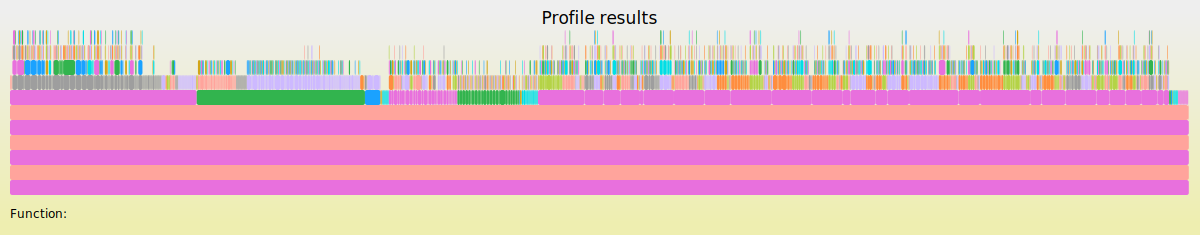

In [24]:
using ProfileView
test(1)
Profile.clear()
@profile test(100000)
ProfileView.view()

In [25]:
function f(a, b)
    a1 = a
    b1 = b
    a1 * b1
end

f (generic function with 1 method)

In [26]:
function g(a, b)
    a * b
end

g (generic function with 1 method)

In [27]:
# @benchmark f(a, b) setup = (a = rand(SMatrix{3, 3}); b = rand(SMatrix{3, 3}))

In [28]:
# @benchmark g(a, b) setup = (a = rand(SMatrix{3, 3}); b = rand(SMatrix{3, 3}))

In [29]:
mass_matrix!(M, state)

In [4]:
using ForwardDiff

In [5]:
const chunk_size = 10

10

In [7]:
nv = num_velocities(mechanism)
const state_autodiff = MechanismState(ForwardDiff.Dual{chunk_size, Float64}, mechanism);
const M_autodiff = Symmetric(Matrix{ForwardDiff.Dual{chunk_size, Float64}}(nv, nv), :U);

In [8]:
function f!(out, q)
    copy!(state_autodiff.q, q)
    mass_matrix!(M_autodiff, state_autodiff)
    @simd for i in eachindex(out)
        out[i] = M_autodiff[i]
    end
end

f! (generic function with 1 method)

In [9]:
q = rand(num_velocities(mechanism));

In [11]:
const out = Matrix{Float64}(nv * nv, num_positions(mechanism))
const y = Vector{Float64}(nv * nv)
ForwardDiff.jacobian!(out, f!, y, q);

In [48]:
@benchmark ForwardDiff.jacobian!(out, f!, y, q) setup = q = rand(num_positions(mechanism))

BenchmarkTools.Trial: 
  memory estimate:  91.00 kb
  allocs estimate:  235
  --------------
  minimum time:     672.767 μs (0.00% GC)
  median time:      706.188 μs (0.00% GC)
  mean time:        712.327 μs (0.99% GC)
  maximum time:     2.718 ms (69.43% GC)
  --------------
  samples:          6981
  evals/sample:     1
  time tolerance:   5.00%
  memory tolerance: 1.00%

In [14]:
@benchmark ForwardDiff.jacobian!($out, $f!, $y, q) setup = q = rand(num_positions(mechanism))

BenchmarkTools.Trial: 
  memory estimate:  90.81 kb
  allocs estimate:  229
  --------------
  minimum time:     620.969 μs (0.00% GC)
  median time:      626.812 μs (0.00% GC)
  mean time:        644.425 μs (0.89% GC)
  maximum time:     2.365 ms (69.38% GC)
  --------------
  samples:          7735
  evals/sample:     1
  time tolerance:   5.00%
  memory tolerance: 1.00%